In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import math
from itertools import combinations_with_replacement

import nibabel as nib
import numpy as np
from scipy import ndimage as ndi
from scipy import spatial, stats
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys, os
sys.path.append(os.path.dirname('../.'))
from scripts.utils import print_img, print_imgs

import torch, torchvision
import torch.nn.functional as F
import cv2

In [3]:
sample_name = "IXI100/IXI100-Guys-0747-MRA"
#sample_name = 'test'
path_to_nii_file = f"/home/msst/TEST/{sample_name}.nii.gz"

vol_file = nib.load(path_to_nii_file)
vol = np.array(vol_file.dataobj)
print(vol.shape)
print(vol.dtype)

(512, 512, 100)
float64


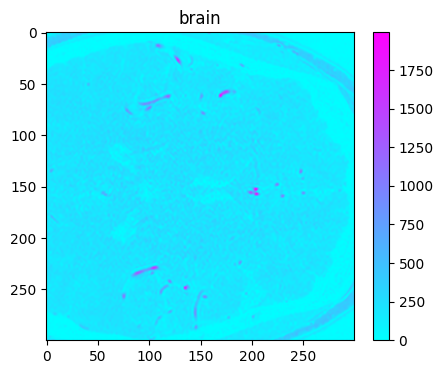

In [4]:
vol_cut = vol[100:400, 100:400]
for idx in range(50, 60, 20):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 1, figsize=(5, 4))    
    print_img(vol_cut, ax, slice_=idx, title='brain', cmap='cool')  

In [32]:
def hessian_matrix(image, sigma=1, mode='constant', cval=0, order='rc',
                   use_gaussian_derivatives=None):
    #image = img_as_float(image)
    #float_dtype = _supported_float_type(image.dtype)
    #image = image.astype(float_dtype, copy=False)
    if image.ndim > 2 and order == "xy":
        raise ValueError("order='xy' is only supported for 2D images.")
    if order not in ["rc", "xy"]:
        raise ValueError(f"unrecognized order: {order}")

    if use_gaussian_derivatives is None:
        use_gaussian_derivatives = False

    if use_gaussian_derivatives:
        return _hessian_matrix_with_gaussian(image, sigma=sigma, mode=mode,
                                             cval=cval, order=order)

    gaussian_filtered = gaussian(image, sigma=sigma, mode=mode, cval=cval)

    gradients = np.gradient(gaussian_filtered)
    axes = range(image.ndim)

    if order == 'xy':
        axes = reversed(axes)

    H_elems = [np.gradient(gradients[ax0], axis=ax1)
               for ax0, ax1 in combinations_with_replacement(axes, 2)]
    return H_elems

In [33]:
out = hessian_matrix(vol_cut)

NameError: name 'gaussian' is not defined

In [9]:
def gaussian_blur_3d(vol_in, kernel_size=5, sigma=2):
    gaussian_kernel = torch.from_numpy(cv2.getGaussianKernel(kernel_size, sigma)).squeeze().float()
    kernel3d = torch.einsum('i,j,k->ijk', gaussian_kernel, gaussian_kernel, gaussian_kernel)
    kernel3d = kernel3d / kernel3d.sum()
    
    print(kernel3d)
    
    blurred_vol = F.conv3d(vol_in, kernel3d.reshape(1, 1, *kernel3d.shape), stride=1,
                           padding=len(gaussian_kernel) // 2)
    return (blurred_vol)

tensor([[[0.0156, 0.0312, 0.0156],
         [0.0312, 0.0625, 0.0312],
         [0.0156, 0.0312, 0.0156]],

        [[0.0312, 0.0625, 0.0312],
         [0.0625, 0.1250, 0.0625],
         [0.0312, 0.0625, 0.0312]],

        [[0.0156, 0.0312, 0.0156],
         [0.0312, 0.0625, 0.0312],
         [0.0156, 0.0312, 0.0156]]])
delta: 11360592.347517014


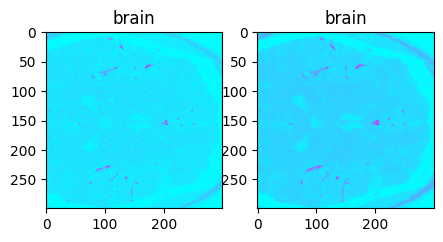

In [12]:
vol_cut = vol[100:400, 100:400]
vol_cut_t = torch.tensor(vol_cut.astype(np.float32)).unsqueeze(0).unsqueeze(0)

blured2 = gaussian_blur_3d(vol_cut_t, kernel_size=3, sigma=0)
blured = scipy.ndimage.gaussian_filter(vol_cut, sigma=0)

print("delta:", np.sum(blured-blured2[0, 0].numpy()))
for idx in range(50, 60, 20):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 2, figsize=(5, 4))    
    print_img(blured, ax[0], slice_=idx, title='brain', cmap='cool', bar=False)  
    print_img(blured2[0, 0], ax[1], slice_=idx, title='brain', cmap='cool', bar=False)  